# Lab 3: CNNs and Deep Learning

## TBMI26/732A55 Neural Networks and Learning Systems

### Michael Felsberg

## 2D Convolution
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

**Task 1:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
    \end{array}$. Visualize the kernel.

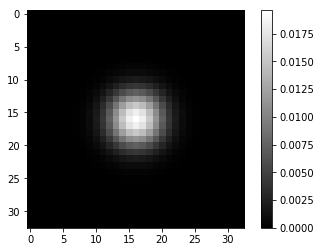

Image size: (33, 33)


In [2]:
# Define the marix h
h = [[0.25, 0.25],[0.25, 0.25]]


import scipy.signal

# Convolute it 5 times on itself and visualize the result
convolution_h1 = scipy.signal.convolve2d(h, h, mode = "full") 
convolution_h2 = scipy.signal.convolve2d(convolution_h1, convolution_h1, mode = "full")
convolution_h3 = scipy.signal.convolve2d(convolution_h2, convolution_h2, mode = "full")
convolution_h4 = scipy.signal.convolve2d(convolution_h3, convolution_h3, mode = "full")
convolution_h5 = scipy.signal.convolve2d(convolution_h4, convolution_h4, mode = "full")
convolution_h5
visualize(convolution_h5)

**Task 2:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), convert it to gray-scale by summing its  R-, G-, and B-values at each pixel, and normalize it to the interval $[0;1]$. Convolve it with $h$ from the previous task with the options `'valid'` and `'same'`. Visualize all three images. What differences do you observe regarding the size and intensity of the output?

/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


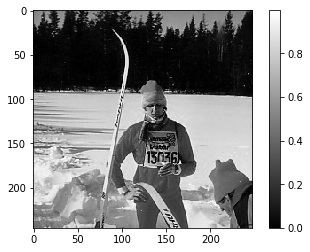

Image size: (246, 248)


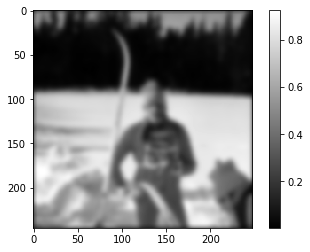

Image size: (246, 248)


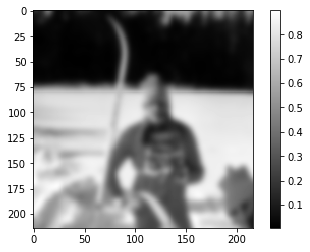

Image size: (214, 216)


In [3]:
import scipy
import scipy.misc
import numpy as np

# Read original image (standard path)
img = scipy.misc.imread("MR15^044.JPG")
# Read original image (path for the kaggle kernel)
#img = scipy.misc.imread("../input/MR15044.JPG")
# visualize(img)

# Normalize it (grey scale)
summed_img = np.sum(img, axis = 2)
normalized_img = summed_img / (255*3)
visualize(normalized_img)
# From 0 to 1, as wanted

# In the text we were asked to make the convolution over h. However, was not that clear what h actually was
# referring to, if to the starting one (2x2) or to the convoluted one (33x33). 
# We used the latter.
convoluted_same_h5 = scipy.signal.convolve2d(normalized_img, convolution_h5, "same")
visualize(convoluted_same_h5)

convoluted_valid_h5 = scipy.signal.convolve2d(normalized_img, convolution_h5, "valid")
visualize(convoluted_valid_h5)

## Answer:

------------------------------------------------------------------------------------------------------------------

In general we can see that the convoluted images are all blurred: the borders of the figures are smoothed and less defined. Regarding the size of the images, the one with option "valid" results in 32 pixels smaller in both hight and width: the convolution does not add any zero when close to the edges, resulting in dimensions smaller of a factor of (k-1), where k is the size of the kernel (in our case, convoluted_h5, that has dimensions 33x33). The final result is similar to the one of a cropping. 

------------------------------------------------------------------------------------------------------------------

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

**Task 3:** Visualize the original gray-scale image and the output image from the previous task (with option `'same'`) with only keping every fifth row and column (stride 5). What do you observe, in particular at the ski?

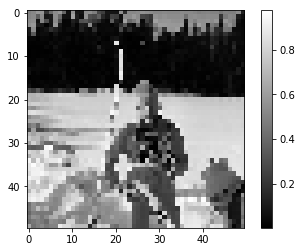

Image size: (50, 50)


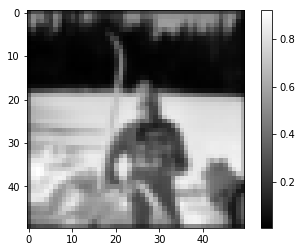

Image size: (50, 50)


In [4]:
# We will show both the original grey-scale image and the convoluted one with applying to both stride 5 

normalized_img_stride5 = normalized_img[::5]
normalized_img_stride5 = np.array(list(map(lambda x: x[::5], normalized_img_stride5)))
visualize(normalized_img_stride5)

convoluted_same_stride5 = convoluted_same_h5[::5]
convoluted_same_stride5 = np.array(list(map(lambda x: x[::5], convoluted_same_stride5)))
visualize(convoluted_same_stride5)

## Answer:

------------------------------------------------------------------------------------------------------------------

Both images appear as "pixellated" but keeping the objects still clearly distinguishable one from the other and from the background. Compared to the original image, the convoluted one is much smoother since all the pixels in the image have been partially mixed together. On the other hand without any transformation the striding gives a pixel pattern with sudden jumps from black to white. For this reason the ski in the original strided image appear as a broken line, while for the convoluted one with striding 5 is instead a smoothed line.

------------------------------------------------------------------------------------------------------------------

## Convolution  in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform *eager execution*. This is initialized as follows:

In [5]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

TensorFlow version 1.14.1-dev20190309
Eager execution activated!


TensorFlow allows to map from and to numpy. Also, operations are automatically casted. In order to get used to TensorFlow and the casting, we repeat the convolution 1.a) from class 5 (see Lisam). As you have learned in the lecture, any convolution with kernel $h$ can also be performed as matrix multiplication by the Toeplitz matrix $H$.

**Task 4:**  Use `scipy.linalg.toeplitz` to generate the matrix $H$ for the kernel $h= \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$ and boundary condition `'same'` and $f= \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$ in TensorFlow (`tf.constant()`). Multiply $H$ and $f$ and display the result. Verify that the result is the same as in 1.a). What are the respective classes of $H$, $f$, and the result?  
    Hints: `scipy.linalg.toeplitz` can take the first column and row as input; `[*np.zeros()]=np.zeros()` (`*` dereferences all elements of a tuple) 

In [6]:
import scipy.linalg
# Define the variables
h = [1,2,-2]
f = [1,-1,-2,0,-1,1,2,-1]

# Create the Toeplitz matrix
H = scipy.linalg.toeplitz(np.concatenate((np.array([2, -2]), np.zeros(8))), 
                             np.concatenate((np.array([2, 1]), np.zeros(8))))
# Make F of suitable type & dimensions
F = np.concatenate((np.array([0]), np.array(f), np.array([0])))

# That's the result we expect (lesson 5, answer 1a)
expected_result = np.array([1,1,-6,-2,3,-1,6,1,-6,2])

# Actual result
computed_result = np.dot(H, F)

print(all(expected_result == computed_result))

True


In [7]:
# What are the classes of H, f and the result?

# H is a Toeplitz matrix, but is stored as a numpy array
print(type(H))
# f is an ordinary numpy array
print(type(F))
# The result is again an ordinary numpy array
print(type(computed_result))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Keras layers can be applied in eager mode using the `tf.keras.layers` package. **NOTE:**  `tf.keras.layers` and **NOT** `keras.layers`.

**Task 5:** Perform the convolution from the previous task using a convolution layer `Conv1D` and a (trivial) `Sequential` model from `tf.keras`.  
Hints: RTFM of `tf.keras.Sequential` - weights can be set for the model (list) or the layer (by traversing the layers list). Apply `use_bias=False` to avoid random DC-shifts.

In [8]:
model_basic_conv = tf.keras.Sequential()
model_basic_conv.add(tf.keras.layers.Conv1D(1, kernel_size=(3), use_bias=False, 
                                            padding='same', input_shape=(8,1)))
# 1: dimension in R^p of the input
# 3 = lenght of the kernel

# NOTE: Default is correlation! You have to flip kernel manually!!

h = np.array([[[[-2,2,1]]]]).transpose((0,3,1,2)).astype(np.float32)
print("That's the shape of h in order to to make the convolution possible:")
print(h.shape)
print("#-----------------------------------------------------------------")

model_basic_conv.set_weights(h)

f = np.array([[0,1,-1,-2,0,-1,1,2,-1,0]]).astype(np.float32)
f = np.expand_dims(f, -1)
print("That's the shape of f in order to to make the convolution possible:")
print(f.shape)
print("#-----------------------------------------------------------------")

out_basic_conv = model_basic_conv(f)
print("Output of the result:")
print(out_basic_conv)

print("#-----------------------------------------------------------------")
print("Is the output we received the same we expected?")
print(all(np.array(tf.squeeze(out_basic_conv)) == expected_result))

That's the shape of h in order to to make the convolution possible:
(1, 3, 1, 1)
#-----------------------------------------------------------------
That's the shape of f in order to to make the convolution possible:
(1, 10, 1)
#-----------------------------------------------------------------
Output of the result:
tf.Tensor(
[[[ 1.]
  [ 1.]
  [-6.]
  [-2.]
  [ 3.]
  [-1.]
  [ 6.]
  [ 1.]
  [-6.]
  [ 2.]]], shape=(1, 10, 1), dtype=float32)
#-----------------------------------------------------------------
Is the output we received the same we expected?
True


**Task 6:** Apply the cascaded $33\times33$ filter from task 1 to the image from task 2 using a `Conv2D` layer. Compare the result visually and by subtracting the fitting result from task 2.

That's the shape of h in order to to make the convolution possible:
(1, 33, 33, 1, 1)

#-------------------------------------------------------------------------------------

That's the shape of the normalized image in order to to make the convolution possible:
(1, 246, 248, 1)

#-------------------------------------------------------------------------------------

That's the shape of the output without any tranformation:
(1, 246, 248, 1)

#-------------------------------------------------------------------------------------

That's the new shape of the output in order to to make the subtraction with the previous image possible:
(246, 248)

#-------------------------------------------------------------------------------------

Original convoluted image:


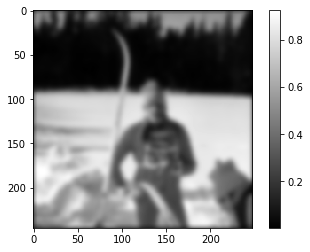

Image size: (246, 248)

Convoluted image:


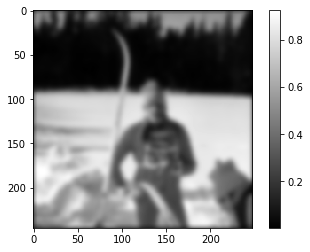

Image size: (246, 248)

Difference:


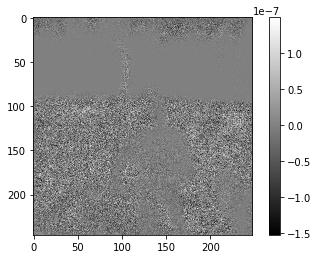

Image size: (246, 248)


In [9]:
model_filtered_image = tf.keras.Sequential()
model_filtered_image.add(tf.keras.layers.Conv2D(1, kernel_size = (33,33), use_bias = False,
                                                padding = "same", input_shape = (246,248,1)))

h = np.array([[[convolution_h5]]])
# Dimensons should be layer, width, height, input, output
h = h.transpose((0,3,4,2,1)).astype(np.float32)
print("That's the shape of h in order to to make the convolution possible:")
print(h.shape)
print("\n#-------------------------------------------------------------------------------------\n")

model_filtered_image.set_weights(h)

normalized_img_expanded = np.array([[normalized_img]]).astype(np.float32)
normalized_img_expanded = normalized_img_expanded.transpose((0,2,3,1))
print("That's the shape of the normalized image in order to to make the convolution possible:")
print(normalized_img_expanded.shape)
print("\n#-------------------------------------------------------------------------------------\n")

out_filtered_image = model_filtered_image(normalized_img_expanded)
print("That's the shape of the output without any tranformation:")
print(out_filtered_image.shape)
print("\n#-------------------------------------------------------------------------------------\n")

out_filtered_image = np.squeeze(out_filtered_image, 0)
print("That's the new shape of the output in order to to make the subtraction with the previous image possible:")
print(out_filtered_image.shape)
print("\n#-------------------------------------------------------------------------------------\n")

print("Original convoluted image:")
visualize(convoluted_same_h5)
print("\nConvoluted image:")
visualize(out_filtered_image)
print("\nDifference:")
visualize(convoluted_same_h5 - out_filtered_image)

**Task 7:** Repeat the previous task with stride 5 and compare the result visually and by subtracting the fitting result from task 3. Repeat the task, but with a $1\times1$ filter (coefficient `1`) and stride 5. Compare again the result visually and by subtracting the fitting result from task 3.  
Hint: You might need to adjust the offset for the subsampling.


Original convoluted strided image:


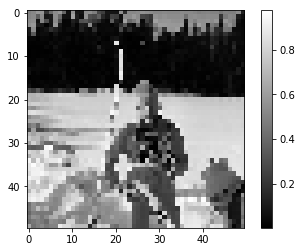

Image size: (50, 50)

Convoluted strided image:


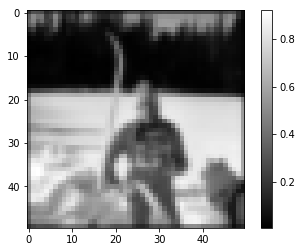

Image size: (50, 50)

Difference (strided):


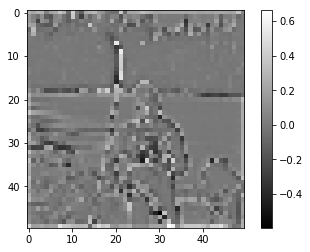

Image size: (50, 50)

#-------------------------------------------------------------------------------------

Let's make it with the 1x1 filter now:

Original convoluted strided image:


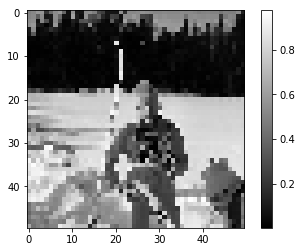

Image size: (50, 50)

Convoluted filter 1 strided image:


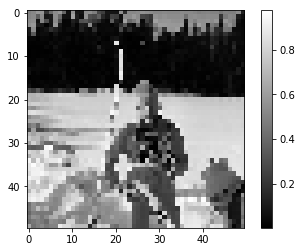

Image size: (50, 50)

Difference filter 1 (strided):


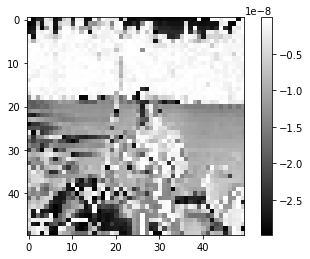

Image size: (50, 50)


In [10]:
model_filtered_image_stride = tf.keras.Sequential()
model_filtered_image_stride.add(tf.keras.layers.Conv2D(1, kernel_size = (33,33), use_bias = False, strides = 5,
                                                       padding = "same", input_shape = (246,248,1)))

model_filtered_image_stride.set_weights(h)

out_filtered_image_stride = model_filtered_image_stride(normalized_img_expanded)
out_filtered_image_stride = np.squeeze(out_filtered_image_stride, 0)

print("\nOriginal convoluted strided image:")
visualize(normalized_img_stride5)
print("\nConvoluted strided image:")
visualize(out_filtered_image_stride)
print("\nDifference (strided):")
visualize(normalized_img_stride5 - out_filtered_image_stride)

print("\n#-------------------------------------------------------------------------------------\n")
print("Let's make it with the 1x1 filter now:")

model_filter1_image_stride = tf.keras.Sequential()
model_filter1_image_stride.add(tf.keras.layers.Conv2D(1, kernel_size = (1,1), use_bias = False, strides = 5,
                                                      padding = "same", input_shape = (246,248,1)))


h1 = np.array([[[[[1]]]]])
h1 = h1.transpose((0,1,2,4,3)).astype(np.float32)

model_filter1_image_stride.set_weights(h1)

'''f = np.array([[normalized_img, normalized_img]]).astype(np.float32)
f = f.transpose((0,2,3,1))
print(f.shape)'''

out_filter1_image_stride = model_filter1_image_stride(normalized_img_expanded)
out_filter1_image_stride = np.squeeze(out_filter1_image_stride, 0)

print("\nOriginal convoluted strided image:")
visualize(normalized_img_stride5)
print("\nConvoluted filter 1 strided image:")
visualize(out_filter1_image_stride)
print("\nDifference filter 1 (strided):")
visualize(normalized_img_stride5 - out_filter1_image_stride)

We now define a new filter that is, unlike $h$, anti-symmetric:

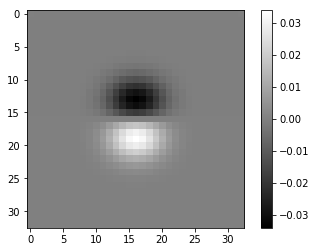

Image size: (33, 33)


In [11]:
fsz = 33
hfsz = 17
h_antisym = convolution_h5
g_antisym = h_antisym*(np.expand_dims(np.arange(-hfsz+1,hfsz),1)@np.ones((1,fsz)))
visualize(g_antisym)

**Task 8:** repeat tasks 6 & 7 with $g$ instead of $h$. What difference do you observe and why?

Original convoluted image:


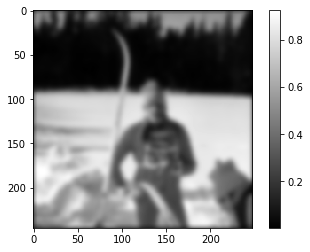

Image size: (246, 248)

Convoluted asymmetric image:


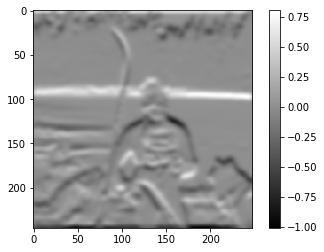

Image size: (246, 248)

Difference (asymmetric):


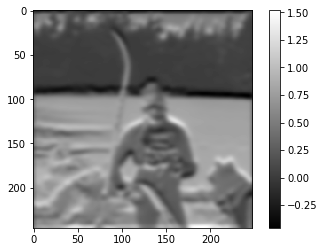

Image size: (246, 248)


In [12]:
# Repeated task 6

model_filter_asymm = tf.keras.Sequential()
model_filter_asymm.add(tf.keras.layers.Conv2D(1, kernel_size = (33,33), use_bias = False, 
                                              padding = "same", input_shape = (246,248,1)))

h_antisym = np.array([[[g_antisym]]])
# Dimensons should be layer, width, height, input, output
h_antisym = h_antisym.transpose((0,3,4,2,1)).astype(np.float32)

model_filter_asymm.set_weights(h_antisym)

out_filter_asymm = model_filter_asymm(normalized_img_expanded)
out_filter_asymm = np.squeeze(out_filter_asymm, 0)

print("Original convoluted image:")
visualize(convoluted_same_h5)
print("\nConvoluted asymmetric image:")
visualize(out_filter_asymm)
print("\nDifference (asymmetric):")
visualize(convoluted_same_h5 - out_filter_asymm)



Original convoluted strided image:


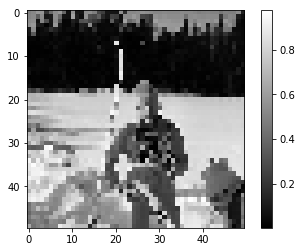

Image size: (50, 50)

Convoluted asymmetric strided image:


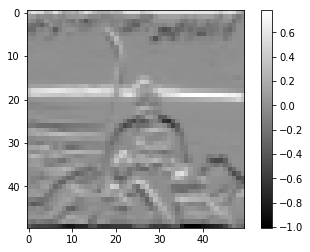

Image size: (50, 50)

Difference (strided asymmetric):


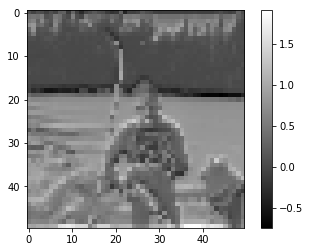

Image size: (50, 50)


In [13]:
# Repeated task 7 (not the 1x1 part)

model_filter_asymm_stride = tf.keras.Sequential()
model_filter_asymm_stride.add(tf.keras.layers.Conv2D(1, kernel_size = (33,33), use_bias = False, strides = 5,
                                                     padding = "same", input_shape = (246,248,1)))

model_filter_asymm_stride.set_weights(h_antisym)

out_filter_asymm_stride = model_filter_asymm_stride(normalized_img_expanded)
out_filter_asymm_stride = np.squeeze(out_filter_asymm_stride, 0)

print("\nOriginal convoluted strided image:")
visualize(normalized_img_stride5)
print("\nConvoluted asymmetric strided image:")
visualize(out_filter_asymm_stride)
print("\nDifference (strided asymmetric):")
visualize(normalized_img_stride5 - out_filter_asymm_stride)

## Training layers
We now take the input and output from task 6 as training data (input and output) for supervised learning of a convolution layer.  
**Task 9:** Although we only have a single input and output image, we can expect the training to work, although this usually requires multiple samples. Why? Define two tensors `batch` and `label` that contain the data from task 6.

In [14]:
batch = np.array([[normalized_img]]).astype(np.float32).transpose((0,2,3,1))
label = model_filtered_image(normalized_img_expanded)


model_train_single_image = tf.keras.Sequential()
model_train_single_image.add(
    tf.keras.layers.Conv2D(
        1, use_bias = False, kernel_size = (33,33),
        padding = "same", input_shape = (246,248,1),
        kernel_constraint=tf.keras.constraints.NonNeg()
    )
)

## Answer:

------------------------------------------------------------------------------------------------------------------

We expect it to work, even though it will probably overfit the training data, because the function to optimize will have infinite optimum values (it is a set of linear equations with many more unknown parameters than equations themselves) and the algorithm will find one of the solutions. 

------------------------------------------------------------------------------------------------------------------

**Task 10:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

In [15]:
def loss(x, y, model = model_train_single_image):
    loss_value = tf.abs(tf.subtract(model(x), y))
    return( tf.reduce_mean(loss_value) )

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  
**Task 11:** Train the model from task 6 (but without assigning the weights) using the data from task 9, the loss from task 10, and `GradientDescentOptimizer()`. During training, print the loss every 100 steps and visualize the learned kernel after training.  
Hint: add a kernel_constraint to be non-negative.

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_steps = 5000

for i in range(train_steps):
    
    with tf.GradientTape() as tape:
        loss_value = loss(batch, label)
        if i%100==0:
            print("Iteration {}; Value of the loss function: {}".format(i,loss_value))
        
    dw = tape.gradient(loss_value, model_train_single_image.variables)
    optimizer.apply_gradients(zip(dw, model_train_single_image.variables))

model_train_single_image.compile(optimizer, loss)
out_train_single_image = model_train_single_image.fit(batch, label, batch_size = 1)

kernel_estimated = model_train_single_image.get_weights()
kernel_estimated = np.array(kernel_estimated)
kernel_estimated_image = np.squeeze(kernel_estimated, (0,3,4))
print(kernel_estimated_image.shape)
visualize(kernel_estimated_image)

Iteration 0; Value of the loss function: 0.1490819901227951


KeyboardInterrupt: 

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM).  
**Extra task (not to be done before task 14 is completed):** Try to improve the result using one or several of the mentioned approaches.